In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 67.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=6fae252e5f172111155564618b5f66f3e8cdcada1c9681bab176de1185714ce8
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Minadzd/Car_sale_ads.csv',
                   
                  )

# zapisanie do csv żeby wczytać do sparkdf, bo wczytanie z pandas df wyrzuca błędy
#df.to_csv('steamdb.csv', index=False)
#df.head(1)

Typy w pandas df:

In [ ]:
df.dtypes

Index                        int64
Price                        int64
Currency                    object
Condition                   object
Vehicle_brand               object
Vehicle_model               object
Vehicle_version             object
Vehicle_generation          object
Production_year              int64
Mileage_km                 float64
Power_HP                   float64
Displacement_cm3           float64
Fuel_type                   object
CO2_emissions              float64
Drive                       object
Transmission                object
Type                        object
Doors_number               float64
Colour                      object
Origin_country              object
First_owner                 object
First_registration_date     object
Offer_publication_date      object
Offer_location              object
Features                    object
dtype: object

Stworzenie spark df i podsumowanie, typy:

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

sparkDF=spark.read.option("header",True) \
.csv('/content/drive/MyDrive/Minadzd/Car_sale_ads.csv')
sparkDF.printSchema()
sparkDF.show()

root
 |-- Index: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Condition: string (nullable = true)
 |-- Vehicle_brand: string (nullable = true)
 |-- Vehicle_model: string (nullable = true)
 |-- Vehicle_version: string (nullable = true)
 |-- Vehicle_generation: string (nullable = true)
 |-- Production_year: string (nullable = true)
 |-- Mileage_km: string (nullable = true)
 |-- Power_HP: string (nullable = true)
 |-- Displacement_cm3: string (nullable = true)
 |-- Fuel_type: string (nullable = true)
 |-- CO2_emissions: string (nullable = true)
 |-- Drive: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Doors_number: string (nullable = true)
 |-- Colour: string (nullable = true)
 |-- Origin_country: string (nullable = true)
 |-- First_owner: string (nullable = true)
 |-- First_registration_date: string (nullable = true)
 |-- Offer_publication_date: string (nullable =

Widzimy, że wszystkie kolumny są stringiem

In [ ]:
sparkDF.count()

208304

Zmiana typów w spark dataframe

In [ ]:
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_date
sparkDF = sparkDF.withColumn("Index", sparkDF["Index"].cast(IntegerType()))
sparkDF = sparkDF.withColumn("Price", sparkDF["Price"].cast(IntegerType()))
sparkDF = sparkDF.withColumn("Production_year", sparkDF["Production_year"].cast(IntegerType()))
sparkDF = sparkDF.withColumn("Mileage_km", sparkDF["Mileage_km"].cast(FloatType()))
sparkDF = sparkDF.withColumn("Power_HP", sparkDF["Power_HP"].cast(FloatType()))
sparkDF = sparkDF.withColumn("Displacement_cm3", sparkDF["Displacement_cm3"].cast(FloatType()))
sparkDF = sparkDF.withColumn("CO2_emissions", sparkDF["CO2_emissions"].cast(FloatType()))
sparkDF = sparkDF.withColumn("Doors_number", sparkDF["Doors_number"].cast(IntegerType()))
sparkDF = sparkDF.withColumn("First_registration_date", to_date(sparkDF["First_registration_date"],'dd/MM/yyyy'))
sparkDF = sparkDF.withColumn("Offer_publication_date", to_date(sparkDF["Offer_publication_date"],'dd/MM/yyyy'))
sparkDF.printSchema()
sparkDF.show()

root
 |-- Index: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Condition: string (nullable = true)
 |-- Vehicle_brand: string (nullable = true)
 |-- Vehicle_model: string (nullable = true)
 |-- Vehicle_version: string (nullable = true)
 |-- Vehicle_generation: string (nullable = true)
 |-- Production_year: integer (nullable = true)
 |-- Mileage_km: float (nullable = true)
 |-- Power_HP: float (nullable = true)
 |-- Displacement_cm3: float (nullable = true)
 |-- Fuel_type: string (nullable = true)
 |-- CO2_emissions: float (nullable = true)
 |-- Drive: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Doors_number: integer (nullable = true)
 |-- Colour: string (nullable = true)
 |-- Origin_country: string (nullable = true)
 |-- First_owner: string (nullable = true)
 |-- First_registration_date: date (nullable = true)
 |-- Offer_publication_date: date (nullable = tru

Podsumowanie danych

In [ ]:
sparkDF.summary().show()

+-------+-----------------+------------------+--------+---------+-------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+---------+------------------+--------------------+------------+-------------+------------------+------+--------------+-----------+--------------------+--------------------+
|summary|            Index|             Price|Currency|Condition|Vehicle_brand|    Vehicle_model|   Vehicle_version|Vehicle_generation|   Production_year|        Mileage_km|         Power_HP| Displacement_cm3|Fuel_type|     CO2_emissions|               Drive|Transmission|         Type|      Doors_number|Colour|Origin_country|First_owner|      Offer_location|            Features|
+-------+-----------------+------------------+--------+---------+-------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+---------+-----------------

Zliczanie wartości brakujących w kolumnach

In [ ]:
from pyspark.sql.functions import  when, count, col
sparkDF = sparkDF.drop("First_registration_date","Offer_publication_date") #select niżej nie działa dla dat
sparkDF.select([count(when(col(c).isNull(), c)).alias(c) for c in sparkDF.columns]).show()

+-----+-----+--------+---------+-------------+-------------+---------------+------------------+---------------+----------+--------+----------------+---------+-------------+-----+------------+----+------------+------+--------------+-----------+--------------+--------+
|Index|Price|Currency|Condition|Vehicle_brand|Vehicle_model|Vehicle_version|Vehicle_generation|Production_year|Mileage_km|Power_HP|Displacement_cm3|Fuel_type|CO2_emissions|Drive|Transmission|Type|Doors_number|Colour|Origin_country|First_owner|Offer_location|Features|
+-----+-----+--------+---------+-------------+-------------+---------------+------------------+---------------+----------+--------+----------------+---------+-------------+-----+------------+----+------------+------+--------------+-----------+--------------+--------+
|    0|    0|       0|        0|            0|            0|          70222|             60444|              0|       983|     643|            1966|        0|       114257|15076|         479|   0|

Vehicle_version, Vehicle_generation, CO2_emissions, Origin_country i First_owner mają za dużo wartości brakujących - te kolumny zostaną usunięte

In [ ]:
sparkDF = sparkDF.drop("Vehicle_version","Vehicle_generation","CO2_emissions","Origin_country","First_owner") 

Usunięcie rekordów z brakującymi wartościami:

In [ ]:
sparkDF = sparkDF.na.drop(subset=["Mileage_km","Power_HP","Displacement_cm3","Drive","Doors_number"])
sparkDF.count()

189776

Sprawdzanie wartości unikalnych dla Currency

In [ ]:
sparkDF.select('Currency').distinct().collect()

[Row(Currency='EUR'), Row(Currency='PLN')]

Zliczanie ile jest razy występuje dana wartość unikalna w kolumnie

In [ ]:
sparkDF_PLN=sparkDF.where(sparkDF["Currency"]=="PLN")
sparkDF_PLN.count()

189607

In [ ]:
sparkDF_EUR=sparkDF.where(sparkDF["Currency"]=="EUR")
sparkDF_EUR.count()

169

Wyników w euro jest bardzo mało porównując do wyników w pln, sądzę, że można je usunąć, żeby mieć jedną walutę

In [ ]:
sparkDF=sparkDF_PLN
sparkDF.count()

189607

In [ ]:
sparkDF=sparkDF.drop("Currency")

Sprawdzenie wartości unikalnych dla Condition

In [ ]:
sparkDF.select('Condition').distinct().collect()

[Row(Condition='Used'), Row(Condition='New')]

Zamiana kolumny Condition na Is_New - w nowej kolumnie będą wartości 0 (zastępuje Used) i 1 (zastępuje New) - dzięki temu będzie można użyć tej kolumny w regresji liniowej

In [ ]:
 from pyspark.sql.functions import regexp_replace
 sparkDF = sparkDF.withColumnRenamed("Condition", "Is_New")
 sparkDF = sparkDF.withColumn('Is_New', regexp_replace('Is_New', 'New', '1'))
 sparkDF = sparkDF.withColumn('Is_New', regexp_replace('Is_New', 'Used', '0'))
 sparkDF = sparkDF.withColumn("Is_New", sparkDF["Is_New"].cast(IntegerType()))

Zliczanie wartości unikalnych dla kolejnych kolumn

In [ ]:
sparkDF.select('Features').distinct().count()

165762

In [ ]:
sparkDF.select('Vehicle_model').distinct().count()

1106

In [ ]:
sparkDF.select('Vehicle_brand').distinct().count()

101

Kolejne kolumny zastępowane są nowymi - dla każdej wartości unikalnej tworzona jest nowa kolumna z wartościami 1 i 0, określającymi czy dana wartość występuje czy nie - w ten sposób nowe kolumny będzie można wykorzystać do regresji liniowej

In [ ]:
sparkDF.select('Transmission').distinct().collect()

[Row(Transmission=None),
 Row(Transmission='Automatic'),
 Row(Transmission='Manual')]

In [ ]:
sparkDF=sparkDF.withColumn('Automatic', when(col("Transmission") == 'Automatic', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Manual', when(col("Transmission") == 'Manual', 1).otherwise(0))
sparkDF=sparkDF.drop("Transmission")

In [ ]:
sparkDF.select('Drive').distinct().collect()

[Row(Drive='Rear wheels'),
 Row(Drive='4x4 (permanent)'),
 Row(Drive='4x4 (attached automatically)'),
 Row(Drive='Front wheels'),
 Row(Drive='4x4 (attached manually)')]

In [ ]:
sparkDF=sparkDF.withColumn('Rear wheels', when(col("Drive") == 'Rear wheels', 1).otherwise(0))
sparkDF=sparkDF.withColumn('4x4 (permanent)', when(col("Drive") == '4x4 (permanent)', 1).otherwise(0))
sparkDF=sparkDF.withColumn('4x4 (attached automatically)', when(col("Drive") == '4x4 (attached automatically)', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Front wheels', when(col("Drive") == 'Front wheels', 1).otherwise(0))
sparkDF=sparkDF.withColumn('4x4 (attached manually)', when(col("Drive") == '4x4 (attached manually)', 1).otherwise(0))
sparkDF=sparkDF.drop("Drive")

In [ ]:
sparkDF.select('Fuel_type').distinct().collect()

[Row(Fuel_type='Gasoline'),
 Row(Fuel_type='Diesel'),
 Row(Fuel_type='Gasoline + LPG'),
 Row(Fuel_type='Hybrid'),
 Row(Fuel_type='Hydrogen'),
 Row(Fuel_type='Gasoline + CNG')]

In [ ]:
sparkDF=sparkDF.withColumn('Gasoline', when(col("Fuel_type") == 'Gasoline', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Diesel', when(col("Fuel_type") == 'Diesel', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Gasoline + LPG', when(col("Fuel_type") == 'Gasoline + LPG', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Hybrid', when(col("Fuel_type") == 'Hybrid', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Hydrogen', when(col("Fuel_type") == 'Hydrogen', 1).otherwise(0))
sparkDF=sparkDF.withColumn('Gasoline + CNG', when(col("Fuel_type") == 'Gasoline + CNG', 1).otherwise(0))
sparkDF=sparkDF.drop("Fuel_type")

In [ ]:
sparkDF.select('Type').distinct().collect()

[Row(Type='small_cars'),
 Row(Type='compact'),
 Row(Type='minivan'),
 Row(Type='coupe'),
 Row(Type='station_wagon'),
 Row(Type='SUV'),
 Row(Type='convertible'),
 Row(Type='city_cars'),
 Row(Type='sedan')]

In [ ]:
sparkDF=sparkDF.withColumn('small_cars', when(col("Type") == 'small_cars', 1).otherwise(0))
sparkDF=sparkDF.withColumn('compact', when(col("Type") == 'compact', 1).otherwise(0))
sparkDF=sparkDF.withColumn('minivan', when(col("Type") == 'minivan', 1).otherwise(0))
sparkDF=sparkDF.withColumn('coupe', when(col("Type") == 'coupe', 1).otherwise(0))
sparkDF=sparkDF.withColumn('station_wagon', when(col("Type") == 'station_wagon', 1).otherwise(0))
sparkDF=sparkDF.withColumn('SUV', when(col("Type") == 'SUV', 1).otherwise(0))
sparkDF=sparkDF.withColumn('convertible', when(col("Type") == 'convertible', 1).otherwise(0))
sparkDF=sparkDF.withColumn('city_cars', when(col("Type") == 'city_cars', 1).otherwise(0))
sparkDF=sparkDF.withColumn('sedan', when(col("Type") == 'sedan', 1).otherwise(0))
sparkDF=sparkDF.drop("Type")

In [ ]:
sparkDF.select('Colour').distinct().collect()

[Row(Colour='violet'),
 Row(Colour='burgundy'),
 Row(Colour='green'),
 Row(Colour='yellow'),
 Row(Colour='silver'),
 Row(Colour='other'),
 Row(Colour='golden'),
 Row(Colour='white'),
 Row(Colour='gray'),
 Row(Colour='red'),
 Row(Colour='beige'),
 Row(Colour='black'),
 Row(Colour='brown'),
 Row(Colour='blue')]

In [ ]:
sparkDF=sparkDF.withColumn('violet', when(col("Colour") == 'violet', 1).otherwise(0))
sparkDF=sparkDF.withColumn('burgundy', when(col("Colour") == 'burgundy', 1).otherwise(0))
sparkDF=sparkDF.withColumn('green', when(col("Colour") == 'green', 1).otherwise(0))
sparkDF=sparkDF.withColumn('yellow', when(col("Colour") == 'yellow', 1).otherwise(0))
sparkDF=sparkDF.withColumn('silver', when(col("Colour") == 'silver', 1).otherwise(0))
sparkDF=sparkDF.withColumn('golden', when(col("Colour") == 'golden', 1).otherwise(0))
sparkDF=sparkDF.withColumn('white', when(col("Colour") == 'white', 1).otherwise(0))
sparkDF=sparkDF.withColumn('gray', when(col("Colour") == 'gray', 1).otherwise(0))
sparkDF=sparkDF.withColumn('red', when(col("Colour") == 'red', 1).otherwise(0))
sparkDF=sparkDF.withColumn('beige', when(col("Colour") == 'beige', 1).otherwise(0))
sparkDF=sparkDF.withColumn('black', when(col("Colour") == 'black', 1).otherwise(0))
sparkDF=sparkDF.withColumn('brown', when(col("Colour") == 'brown', 1).otherwise(0))
sparkDF=sparkDF.withColumn('blue', when(col("Colour") == 'blue', 1).otherwise(0))
sparkDF=sparkDF.drop("Colour")

In [ ]:
sparkDF.show()
sparkDF.summary().show()

+-----+------+------+-------------+-------------+---------------+----------+--------+----------------+------------+--------------------+--------------------+---------+------+-----------+---------------+----------------------------+------------+-----------------------+--------+------+--------------+------+--------+--------------+----------+-------+-------+-----+-------------+---+-----------+---------+-----+------+--------+-----+------+------+------+-----+----+---+-----+-----+-----+----+
|Index| Price|Is_New|Vehicle_brand|Vehicle_model|Production_year|Mileage_km|Power_HP|Displacement_cm3|Doors_number|      Offer_location|            Features|Automatic|Manual|Rear wheels|4x4 (permanent)|4x4 (attached automatically)|Front wheels|4x4 (attached manually)|Gasoline|Diesel|Gasoline + LPG|Hybrid|Hydrogen|Gasoline + CNG|small_cars|compact|minivan|coupe|station_wagon|SUV|convertible|city_cars|sedan|violet|burgundy|green|yellow|silver|golden|white|gray|red|beige|black|brown|blue|
+-----+------+----

Regresja liniowa

In [ ]:
sparkDF = sparkDF.drop("Features") #wyrzucana jest tylko przez nazwę, która koliduje w modelu regresji, potem można zmienić nazwę kolumny features w modelu i zostawić tę
train, test=sparkDF.randomSplit([0.6,0.4]) #dzielenie na zbiór testowy i treningowy

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
columns = ["Is_New","Production_year","Mileage_km","Power_HP","Displacement_cm3","Doors_number","Automatic","Manual","Rear wheels","4x4 (permanent)","4x4 (attached automatically)","Front wheels","4x4 (attached manually)","Gasoline","Diesel","Gasoline + LPG","Hybrid","Hydrogen","Gasoline + CNG","small_cars","compact","minivan","coupe","station_wagon","SUV","convertible","city_cars","sedan","violet","burgundy","green","yellow","silver","golden","white","gray","red","beige","black","brown","blue"]
assembler = VectorAssembler(inputCols=columns, outputCol="features") #żeby regresja działała trzeba zebrać wszystkie kolumny z danymi niezależnymi w wektor
assembled = assembler.transform(train)
lr = LinearRegression(featuresCol="features",labelCol="Price") #regresja liniowa, przewidywane będą wartości kolumny Price
lrModel = lr.fit(assembled)

Wyświetlenie wartości współczynników modelu

In [ ]:
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [52274.576754605056,1046.2392295410584,-0.17881862231717388,785.5253948603582,-22.451729782188526,-2987.2578435992637,5449.223908144519,2681.699179895801,-9364.043223521207,14945.902714929216,7772.193778264526,-5096.337705858696,1446.898297952531,-10555.296101479544,10161.816663865131,-8420.188638551526,16260.127709289649,135679.63065085805,1995.4639270087448,8752.967736197572,-1164.7699849807389,2983.7730345888417,-813.3389028920477,-4071.162131175543,552.7837344174343,5216.317144538473,7189.197364719312,-4100.762002564937,2406.9812696062922,1475.2872788623051,16009.499101080199,11158.836899286553,1250.2046710157615,1521.778560768865,2387.1316470575716,2516.305381866526,2657.870558598498,3368.833935534717,1179.736043018278,646.6321548021339,4268.028187042433]
Intercept: -2090117.071527147


Wyświetlenie wartości przewidywanych, wartości faktycznych i oceny modelu (wzór skopiowany ze stacka)

In [ ]:
from  pyspark.sql.functions import abs
assembled = assembler.transform(test)
predictions = lrModel.transform(assembled)
x =((predictions['Price']-predictions['prediction'])/predictions['Price'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","Price","Accuracy","features").show()

+------------------+------+------------------+--------------------+
|        prediction| Price|          Accuracy|            features|
+------------------+------+------------------+--------------------+
| 178767.7344168818| 67000|166.81751405504747|(41,[1,2,3,4,5,7,...|
|102706.23388778442| 31900| 221.9631156356878|(41,[1,2,3,4,5,7,...|
| 96652.50590875302| 36000| 168.4791830798695|(41,[1,2,3,4,5,7,...|
| 147508.4607780187| 80900| 82.33431492956575|(41,[0,1,2,3,4,5,...|
| 177702.7922784353|127921| 38.91604371325686|(41,[0,1,2,3,4,5,...|
| 77557.77694548131| 22900|238.68024867022405|(41,[1,2,3,4,5,7,...|
| 69912.12713962025| 42900| 62.96533132778613|(41,[1,2,3,4,5,7,...|
| 61939.73941808683| 40900| 51.44190566769395|(41,[1,2,3,4,5,7,...|
| 162786.8945705637|113500| 43.42457671415303|(41,[0,1,2,3,4,5,...|
|  74943.8844627419| 59990| 24.92729532045658|(41,[1,2,3,4,5,7,...|
|155629.12866103207|116090| 34.05903063229569|(41,[0,1,2,3,4,5,...|
| 67237.23774495604| 25900|159.60323453650983|(4

Podsumowanie modelu

In [ ]:
predictions.select("prediction","Price","Accuracy").summary().show()

+-------+-------------------+------------------+--------------------+
|summary|         prediction|             Price|            Accuracy|
+-------+-------------------+------------------+--------------------+
|  count|              76023|             76023|               76023|
|   mean|  62938.25917915836|63060.745221840756|   85.59916062031682|
| stddev|   68160.7638832653| 84970.97575058421|   191.4564494439971|
|    min|-1800468.6949058925|               650|0.001129551335754...|
|    25%|  16644.56700445502|             17900|  17.761258181228293|
|    50%| 44687.789539079415|             36500|   39.61474841930638|
|    75%|  95770.34941196511|             76000|   90.53061292730484|
|    max|  949209.0678751043|           2583000|  13732.103810453811|
+-------+-------------------+------------------+--------------------+



W materiałach do zajęć było o tym, ale nie mam pojęcia jak to działa. Ma niby służyć do oceny modelu

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Price",metricName="r2")
evaluator.evaluate(predictions)

0.642853411181302

In [ ]:
evaluator = RegressionEvaluator(labelCol="Price",metricName="rmse")
evaluator.evaluate(predictions)

50779.80190114135

In [ ]:
model_summary = lrModel.summary
print("RMSE: %f" % model_summary.rootMeanSquaredError)
print("r2: %f" % model_summary.r2)

RMSE: 50889.012226
r2: 0.640282


Random Forest Regression dla danych przed standaryzacją

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(train)
rfr = RandomForestRegressor(featuresCol="features",labelCol="Price")
rfrModel = rfr.fit(assembled)
print(rfrModel.params)

[Param(parent='RandomForestRegressor_75c045acd41d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'), Param(parent='RandomForestRegressor_75c045acd41d', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'), Param(parent='RandomForestRegressor_75c045acd41d', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'), Param(parent='RandomForestRegressor_75c045acd41d', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (c

In [ ]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(test)
predictions = rfrModel.transform(assembled)
x =((predictions['Price']-predictions['prediction'])/predictions['Price'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","Price","Accuracy","features").show()

+------------------+------+------------------+--------------------+
|        prediction| Price|          Accuracy|            features|
+------------------+------+------------------+--------------------+
| 114397.7744689252| 67000| 70.74294696854507|(41,[1,2,3,4,5,7,...|
| 29833.92562878121| 31900| 6.476722166830064|(41,[1,2,3,4,5,7,...|
|29068.727527133586| 36000| 19.25353464685115|(41,[1,2,3,4,5,7,...|
| 99263.19918686282| 80900| 22.69863929154861|(41,[0,1,2,3,4,5,...|
| 129817.7244642834|127921| 1.482731110828869|(41,[0,1,2,3,4,5,...|
|19866.335734545366| 22900|13.247442207225477|(41,[1,2,3,4,5,7,...|
|63101.234067652396| 42900| 47.08912370082144|(41,[1,2,3,4,5,7,...|
| 24206.44552174428| 40900| 40.81553662165213|(41,[1,2,3,4,5,7,...|
| 109517.0389811837|113500|3.5092167566663486|(41,[0,1,2,3,4,5,...|
|55713.764050406906| 59990| 7.128247957314709|(41,[1,2,3,4,5,7,...|
|109469.48953691954|116090| 5.702911933052335|(41,[0,1,2,3,4,5,...|
|19964.142656507105| 25900|22.918368121594188|(4

In [ ]:
predictions.select("prediction","Price","Accuracy").summary().show()
evaluator = RegressionEvaluator(labelCol="Price",metricName="r2")
evaluator.evaluate(predictions)

+-------+------------------+------------------+--------------------+
|summary|        prediction|             Price|            Accuracy|
+-------+------------------+------------------+--------------------+
|  count|             76023|             76023|               76023|
|   mean| 62867.24402934833|63060.745221840756|    48.0457006594152|
| stddev| 65853.61076103839| 84970.97575058421|    92.6720678440065|
|    min|14487.234512921219|               650|0.001093554971345...|
|    25%|20908.398364611196|             17900|   9.688521383582547|
|    50%| 40360.18837868395|             36500|   21.75102866980973|
|    75%| 79380.16645654969|             76000|  44.613377699571025|
|    max| 602483.4802375922|           2583000|  3865.1832556880613|
+-------+------------------+------------------+--------------------+



0.7668188813291974

In [ ]:
evaluator = RegressionEvaluator(labelCol="Price",metricName="rmse")
evaluator.evaluate(predictions)

41031.22090481742

Regresja liniowa ze standaryzacją

Standaryzacja danych:

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
for i in ["Production_year","Mileage_km","Power_HP","Displacement_cm3","Doors_number"]:
  assembler = VectorAssembler(inputCols=[i], outputCol=i+"_assembled")
  standardScaler = StandardScaler(inputCol=i+"_assembled",outputCol=i+"_scaled")
  pipeline = Pipeline(stages=[assembler, standardScaler])
  sparkDF = pipeline.fit(sparkDF).transform(sparkDF).withColumn(i+"_scaled", unlist(i+"_scaled")).drop(i+"_assembled")
sparkDF.show()

+-----+------+------+-------------+-------------+---------------+----------+--------+----------------+------------+--------------------+---------+------+-----------+---------------+----------------------------+------------+-----------------------+--------+------+--------------+------+--------+--------------+----------+-------+-------+-----+-------------+---+-----------+---------+-----+------+--------+-----+------+------+------+-----+----+---+-----+-----+-----+----+----------------------+-----------------+---------------+-----------------------+-------------------+
|Index| Price|Is_New|Vehicle_brand|Vehicle_model|Production_year|Mileage_km|Power_HP|Displacement_cm3|Doors_number|      Offer_location|Automatic|Manual|Rear wheels|4x4 (permanent)|4x4 (attached automatically)|Front wheels|4x4 (attached manually)|Gasoline|Diesel|Gasoline + LPG|Hybrid|Hydrogen|Gasoline + CNG|small_cars|compact|minivan|coupe|station_wagon|SUV|convertible|city_cars|sedan|violet|burgundy|green|yellow|silver|golde

In [ ]:
columns[columns.index("Production_year")]="Production_year_scaled"
columns[columns.index("Mileage_km")]="Mileage_km_scaled"
columns[columns.index("Power_HP")]="Power_HP_scaled"
columns[columns.index("Displacement_cm3")]="Displacement_cm3_scaled"
columns[columns.index("Doors_number")]="Doors_number_scaled"

In [ ]:
train, test=sparkDF.randomSplit([0.6,0.4])
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(train)
lr = LinearRegression(featuresCol="features",labelCol="Price")
lrModel = lr.fit(assembled)
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [51647.34208772517,7122.45470040559,-18887.618785407263,59204.49858651613,-14471.81271959279,-2736.0991676475405,14880.685767734949,12631.643577022203,-9881.632350118949,14415.161514091098,8028.9806861912475,-4720.575870756606,1362.7167072318832,-10222.389046043067,9800.169769008302,-8482.716513165833,16777.199221831434,139171.88041623853,8571.647495630834,9233.09699233848,-883.5641096550543,2857.893618306628,-814.5368860427236,-4087.4285936328906,430.2492174909312,5480.132005556236,7064.478023767034,-4088.2984732574314,2782.8605345110313,1358.5635033242152,15865.269974633144,15045.146541754964,883.5488556471253,-408.407536067511,2437.946231647769,2510.965986183243,2917.1369754965085,5013.571733596117,893.1151423816932,504.2836064499183,4395.860410566291]
Intercept: -2204315.1250542174


In [ ]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(test)
predictions = lrModel.transform(assembled)
x =((predictions['Price']-predictions['prediction'])/predictions['Price'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","Price","Accuracy","features").show()

+------------------+------+------------------+--------------------+
|        prediction| Price|          Accuracy|            features|
+------------------+------+------------------+--------------------+
|149887.46656988002| 86200| 73.88337189081209|(41,[0,1,3,4,5,7,...|
| 95339.82501220237| 39900| 138.9469298551438|(41,[1,2,3,4,5,7,...|
|149930.88200803893| 93100|61.042837817442454|(41,[0,1,3,4,5,7,...|
|179427.49004204012| 67000|167.80222394334348|(41,[1,2,3,4,5,7,...|
|102428.58290819591| 31900|221.09273638932888|(41,[1,2,3,4,5,7,...|
|115981.38329702476| 70000| 65.68769042432109|(41,[1,2,3,4,5,7,...|
| 64308.27925662976| 38500|  67.0344915756617|(41,[1,2,3,4,5,7,...|
| 69464.24359279824| 41400| 67.78802800192813|(41,[1,2,3,4,5,7,...|
|149196.77953533083| 80900|  84.4212355195684|(41,[0,1,3,4,5,7,...|
|118836.91056358255| 75500| 57.39988154116895|(41,[1,2,3,4,5,7,...|
|104536.34741347004| 92000|13.626464579858736|(41,[1,2,3,4,5,7,...|
| 66266.97551555373| 45900| 44.37249567658764|(4

In [ ]:
predictions.select("prediction","Price","Accuracy").summary().show()

+-------+------------------+-----------------+--------------------+
|summary|        prediction|            Price|            Accuracy|
+-------+------------------+-----------------+--------------------+
|  count|             75956|            75956|               75956|
|   mean| 63162.99382505473|63368.42782663647|   86.11437097086917|
| stddev| 68540.80046869435|87317.31262118848|   194.3154910978853|
|    min|-1837115.086351211|              585|2.041831516228706...|
|    25%|16391.857502693776|            17900|  17.695979238600536|
|    50%|44709.829945679754|            36500|   39.69116344399827|
|    75%|  96728.5233958019|            76900|   91.07658094019013|
|    max| 866433.3651740937|          6999000|  17683.422930195262|
+-------+------------------+-----------------+--------------------+



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Price",metricName="r2")
evaluator.evaluate(predictions)

0.6063298297469819

In [ ]:
evaluator = RegressionEvaluator(labelCol="Price",metricName="rmse")
evaluator.evaluate(predictions)

54785.26365516353

In [ ]:
model_summary = lrModel.summary
print("RMSE: %f" % model_summary.rootMeanSquaredError)
print("r2: %f" % model_summary.r2)

RMSE: 48024.454232
r2: 0.667148


Random Forest Regression dla danych po standaryzacji

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(train)
rfr = RandomForestRegressor(featuresCol="features",labelCol="Price")
rfrModel = rfr.fit(assembled)
print(rfrModel.params)

[Param(parent='RandomForestRegressor_2ca771101318', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'), Param(parent='RandomForestRegressor_2ca771101318', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'), Param(parent='RandomForestRegressor_2ca771101318', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'), Param(parent='RandomForestRegressor_2ca771101318', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (c

In [ ]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembled = assembler.transform(test)
predictions = rfrModel.transform(assembled)
x =((predictions['Price']-predictions['prediction'])/predictions['Price'])*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","Price","Accuracy","features").show()

+------------------+------+------------------+--------------------+
|        prediction| Price|          Accuracy|            features|
+------------------+------+------------------+--------------------+
| 95241.15388814243| 86200| 10.48857759645294|(41,[0,1,3,4,5,7,...|
|44107.948429700715| 39900|10.546236665916577|(41,[1,2,3,4,5,7,...|
| 95241.15388814243| 93100|2.2998430592292536|(41,[0,1,3,4,5,7,...|
|115379.21050359355| 67000| 72.20777687103515|(41,[1,2,3,4,5,7,...|
|25499.901433264607| 31900|20.063004911396217|(41,[1,2,3,4,5,7,...|
| 57968.09730736465| 70000|17.188432418050496|(41,[1,2,3,4,5,7,...|
| 37050.61653848442| 38500|3.7646323675729327|(41,[1,2,3,4,5,7,...|
|39731.176472011815| 41400|  4.03097470528547|(41,[1,2,3,4,5,7,...|
| 95241.15388814243| 80900|17.727013458766915|(41,[0,1,3,4,5,7,...|
| 84980.54577570884| 75500|12.557014272462045|(41,[1,2,3,4,5,7,...|
| 68509.58629744811| 92000|25.533058372339006|(41,[1,2,3,4,5,7,...|
|37598.449382716746| 45900|18.086166922185736|(4

In [ ]:
predictions.select("prediction","Price","Accuracy").summary().show()

+-------+------------------+-----------------+--------------------+
|summary|        prediction|            Price|            Accuracy|
+-------+------------------+-----------------+--------------------+
|  count|             75956|            75956|               75956|
|   mean| 63408.33012321691|63368.42782663647|   49.02573547323362|
| stddev| 67468.14578898234|87317.31262118848|  106.90200877116398|
|    min| 15019.93341215509|              585|9.169447084833593E-4|
|    25%|21045.617835484973|            17900|   9.884289106536585|
|    50%|39809.558076220055|            36500|  22.130733730515768|
|    75%| 79419.78291039789|            76900|   45.59045627263319|
|    max| 688096.6638983382|          6999000|  12792.216430068613|
+-------+------------------+-----------------+--------------------+



In [ ]:
evaluator = RegressionEvaluator(labelCol="Price",metricName="r2")
evaluator.evaluate(predictions)

0.7269729690301945

In [ ]:
evaluator = RegressionEvaluator(labelCol="Price",metricName="rmse")
evaluator.evaluate(predictions)

45624.73187239287

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


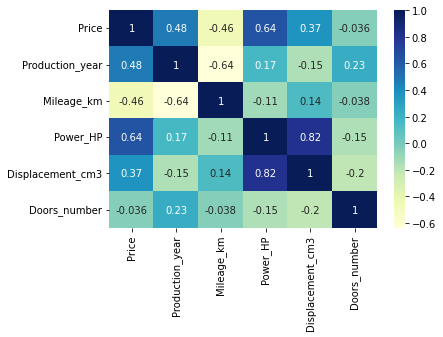

In [ ]:
from pyspark.ml.stat import Correlation
import seaborn as sb
import matplotlib.pyplot as mp

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["Price","Production_year","Mileage_km","Power_HP","Displacement_cm3","Doors_number"], 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(sparkDF).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

dataplot = sb.heatmap(cor_np, xticklabels=["Price","Production_year","Mileage_km","Power_HP","Displacement_cm3","Doors_number"], yticklabels=["Price","Production_year","Mileage_km","Power_HP","Displacement_cm3","Doors_number"],  cmap="YlGnBu", annot=True)
mp.show()